In [2]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

from collections import Counter

from sklearn.impute import KNNImputer

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, f1_score

import joblib


In [3]:
def LoadData():
    rawDataset = pd.read_csv('diabetes.csv')
    return rawDataset

In [4]:
def ImputeData(rawDataset, threshold):

    dataset = rawDataset.copy()

    features = list(dataset)[:-1]

    for feature in features:
        ratio = (dataset[feature] == 0).mean()
        if 0 < ratio < threshold:
            dataset.loc[dataset[feature] == 0, feature] = np.nan
            print(feature, ratio)
    
    imputer = KNNImputer(n_neighbors=3)
    imputedData = imputer.fit_transform(dataset)
    imputedData = pd.DataFrame(imputedData, columns=rawDataset.columns)

    return imputedData

In [5]:
def Preprocess(rawDataset, threshold):

    outlierIndices = []
    features = list(rawDataset)[:-1]

    for feature in features:

        Q1 = np.percentile(rawDataset[feature], 25)
        Q3 = np.percentile(rawDataset[feature],75)
        IQR = Q3 - Q1
        outlierStep = 1.5 * IQR
        
        outlierIndices.extend(rawDataset[(rawDataset[feature] < Q1 - outlierStep) 
        | (rawDataset[feature] > Q3 + outlierStep )].index)

    outlierIndices = Counter(outlierIndices)
    outlierIndices = list(k for k, v in outlierIndices.items() if v > threshold )

    rawDataset.drop(outlierIndices, axis = 0).reset_index(drop=True)
    dataset = rawDataset.values[:,:-1]
    label = rawDataset.values[:,-1]
 
    return dataset, label

In [6]:
def BuidModel(modelKey):
    if modelKey == 'svm':

        return SVC(probability=True, random_state=0)
    
    elif modelKey == 'rf':
        
        return RandomForestClassifier(n_estimators=512, random_state=0)

    elif modelKey == 'mlp':

        return MLPClassifier(max_iter=10000, random_state=0)
    
    elif modelKey == 'logistic':
        
        return LogisticRegression(random_state=0)
    
    elif modelKey == 'nb':

        return GaussianNB()
    
    elif modelKey == 'dt':
        
        return DecisionTreeClassifier(random_state=0)
    
    elif modelKey == 'knn':

        return KNeighborsClassifier()
    


In [7]:
def TrainTestModel(dataset, label, processKey, modelKeyList, K):
    
    trainingPrecision = np.zeros(K)
    trainingRecall = np.zeros(K)
    traingAuc = np.zeros(K)
    traingAupr = np.zeros(K)
    traingF1 = np.zeros(K)

    validationPrecision = np.zeros(K)
    validationRecall = np.zeros(K)
    validationAuc = np.zeros(K)
    validationAupr = np.zeros(K)
    validationF1 = np.zeros(K)

    # smo = SMOTE(random_state=0)
    # dataset, label = smo.fit_resample(dataset, label)

    kFold = StratifiedKFold(n_splits=K)
    
    for (k, (trainingIndex, validationIndex)) in enumerate(kFold.split(dataset, label)):

        trainingData, validationData = dataset[trainingIndex], dataset[validationIndex]
        trainingLabel, validationLabel = label[trainingIndex], label[validationIndex]

        if processKey == 'standard':
            scaler = StandardScaler()
        elif processKey == 'minMax':
            scaler = MinMaxScaler()

        trainingData = scaler.fit_transform(trainingData)
        validationData = scaler.transform(validationData)
        
        # smo = SMOTE(random_state=0)
        # trainingData, trainingLabel = smo.fit_resample(trainingData, trainingLabel)

        modelList = []
        traingingProbablityList = []
        traingPredictLabelList = []
        validationProbablityList = []
        validationPredictLabelList = []

        for modelKey in modelKeyList:
            
            model = BuidModel(modelKey)
            model.fit(trainingData, trainingLabel)

            modelList.append(model)

            traingingProbablity = model.predict_proba(trainingData)[:, 1]
            traingPredictLabel = model.predict(trainingData)

            traingingProbablityList.append(traingingProbablity)
            traingPredictLabelList.append(traingPredictLabel)

            validationProbablity = model.predict_proba(validationData)[:, 1]
            validationPredictLabel = model.predict(validationData)

            validationProbablityList.append(validationProbablity)
            validationPredictLabelList.append(validationPredictLabel)

            if k == 0:
                joblib.dump(model, 'model/{}.pkl'.format(modelKey))

        if len(modelKeyList) > 1:

            traingingProbablityList = np.array(traingingProbablityList).T
            traingPredictLabelList = np.array(traingPredictLabelList).T
            validationProbablityList = np.array(validationProbablityList).T
            validationPredictLabelList = np.array(validationPredictLabelList).T

            combinerKey = 'combiner'

            model = BuidModel(combinerKey)
            model.fit(traingingProbablityList, trainingLabel)

            traingingProbablity = model.predict_proba(traingingProbablityList)[:, 1]
            traingPredictLabel = model.predict(traingingProbablityList)

            validationProbablity = model.predict_proba(validationProbablityList)[:, 1]
            validationPredictLabel = model.predict(validationProbablityList)

            if k == 0:
                joblib.dump(model, 'model/{}.pkl'.format(combinerKey))
            
        trainingPrecision[k] = precision_score(trainingLabel, traingPredictLabel)
        trainingRecall[k] = recall_score(trainingLabel, traingPredictLabel)
        traingAuc[k] = roc_auc_score(trainingLabel, traingingProbablity)
        traingAupr[k] = average_precision_score(trainingLabel, traingingProbablity)
        traingF1[k] = f1_score(trainingLabel, traingPredictLabel)

        print('*****************k={0}*****************'.format(k))
        print('Training Precision:', trainingPrecision[k])
        print('Training Recall:', trainingRecall[k])
        print('Training auc:', traingAuc[k])
        print('Training aupr:', traingAupr[k])
        print('Training f1:', traingF1[k])

        validationPrecision[k] = precision_score(validationLabel, validationPredictLabel)
        validationRecall[k] = recall_score(validationLabel, validationPredictLabel)
        validationAuc[k] = roc_auc_score(validationLabel, validationProbablity)
        validationAupr[k] = average_precision_score(validationLabel, validationProbablity)
        validationF1[k] = f1_score(validationLabel, validationPredictLabel)

        print('Validation Precision:', validationPrecision[k])
        print('Validation Recall:', validationRecall[k])
        print('Validation auc:', validationAuc[k])
        print('Validation aupr:', validationAupr[k])
        print('Validation f1:', validationF1[k])
    

    print('**********************************')
    print('**********************************')
    print('**********************************')
    print('Mean Training Precision:', trainingPrecision.mean())
    print('Mean Training Recall:', trainingRecall.mean())
    print('Mean Training auc:', traingAuc.mean())
    print('Mean Training aupr:', traingAupr.mean())
    print('Mean Training f1:', traingF1.mean())

    print('Mean Validation Precision:', validationPrecision.mean())
    print('Mean Validation Recall:', validationRecall.mean())
    print('Mean Validation auc:', validationAuc.mean())
    print('Mean Validation aupr:', validationAupr.mean())
    print('Mean Validation f1:', validationF1.mean())
    


In [9]:
rawDataset = LoadData()
# imputedData = ImputeData(rawDataset, 0.1)
dataset, label = Preprocess(rawDataset, 1)
modelList = ['svm', 'rf', 'mlp', 'logistic', 'nb', 'dt', 'knn']

TrainTestModel(dataset, label, 'minMax', modelList, K=10)

*****************k=0*****************
Training Precision: 1.0
Training Recall: 1.0
Training auc: 1.0
Training aupr: 1.0
Training f1: 1.0
Validation Precision: 0.5483870967741935
Validation Recall: 0.6296296296296297
Validation auc: 0.7851851851851852
Validation aupr: 0.6483406772070068
Validation f1: 0.5862068965517241
*****************k=1*****************
Training Precision: 1.0
Training Recall: 1.0
Training auc: 1.0
Training aupr: 1.0
Training f1: 1.0
Validation Precision: 0.7619047619047619
Validation Recall: 0.5925925925925926
Validation auc: 0.8318518518518518
Validation aupr: 0.797889539435674
Validation f1: 0.6666666666666666
*****************k=2*****************
Training Precision: 1.0
Training Recall: 1.0
Training auc: 1.0
Training aupr: 1.0
Training f1: 1.0
Validation Precision: 0.6818181818181818
Validation Recall: 0.5555555555555556
Validation auc: 0.8355555555555555
Validation aupr: 0.7452511924210958
Validation f1: 0.6122448979591836
*****************k=3*****************


C:\Users\16011\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


*****************k=4*****************
Training Precision: 1.0
Training Recall: 1.0
Training auc: 1.0
Training aupr: 1.0
Training f1: 1.0
Validation Precision: 0.75
Validation Recall: 0.4444444444444444
Validation auc: 0.8162962962962963
Validation aupr: 0.721472473759663
Validation f1: 0.5581395348837209
*****************k=5*****************
Training Precision: 1.0
Training Recall: 1.0
Training auc: 1.0
Training aupr: 1.0
Training f1: 1.0
Validation Precision: 0.6956521739130435
Validation Recall: 0.5925925925925926
Validation auc: 0.8540740740740741
Validation aupr: 0.786437823921029
Validation f1: 0.6399999999999999
*****************k=6*****************
Training Precision: 1.0
Training Recall: 1.0
Training auc: 1.0
Training aupr: 1.0
Training f1: 1.0
Validation Precision: 0.8095238095238095
Validation Recall: 0.6296296296296297
Validation auc: 0.8666666666666667
Validation aupr: 0.7638305198982809
Validation f1: 0.7083333333333334
*****************k=7*****************
Training Precis

In [157]:
dataset, imputedData = ImputeData(rawDataset, 0.1)

In [141]:
(dataset['BMI'] == np.nan).mean()

0.0

In [139]:
imputedData

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,1.0


In [75]:
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(rawDataset)
df_imputed = pd.DataFrame(imputed, columns=rawDataset.columns)

In [76]:
rawDataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [96]:
rawDataset.copy()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Pregnancies


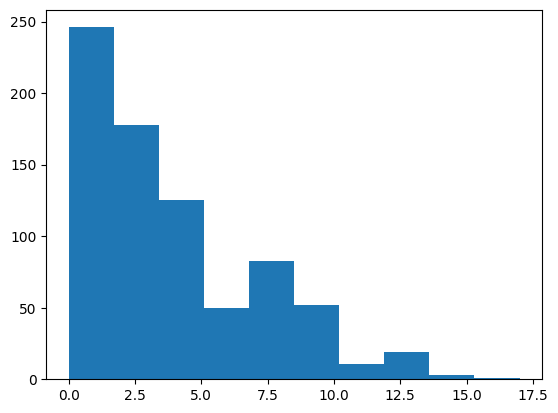

Glucose


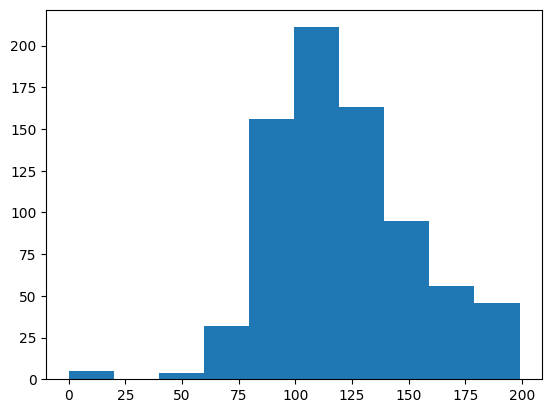

BloodPressure


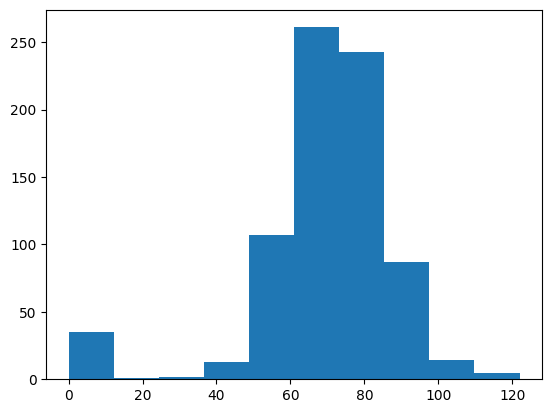

SkinThickness


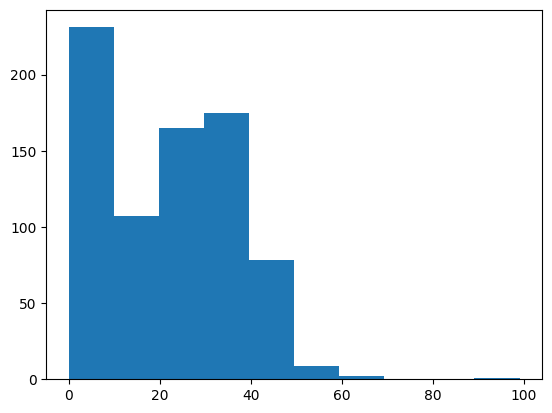

Insulin


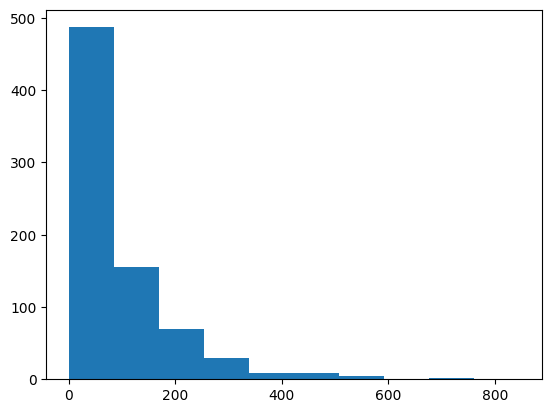

BMI


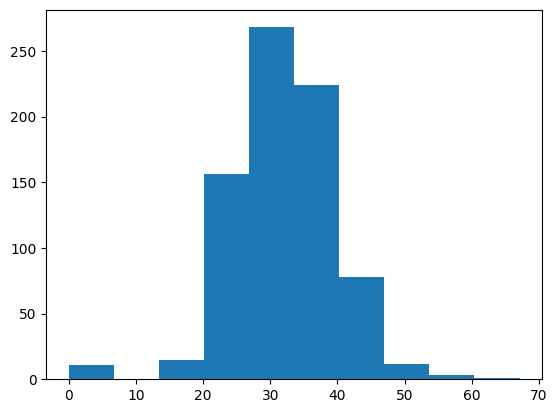

DiabetesPedigreeFunction


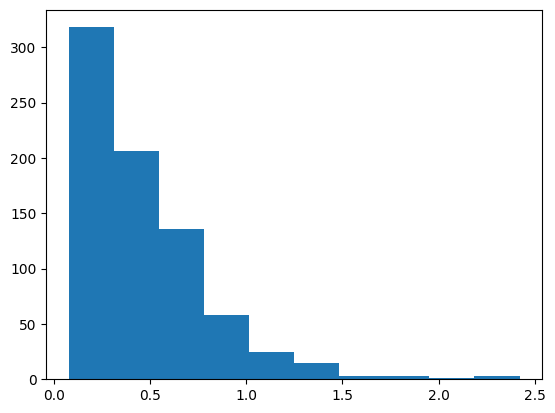

Age


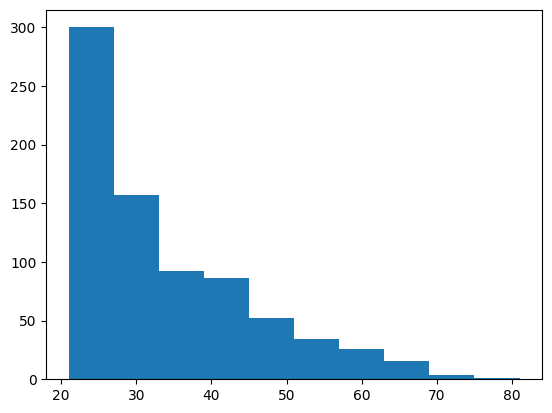

In [92]:
for x in list(rawDataset)[:-1]:
    print(x)
    plt.hist(rawDataset[x])
    plt.show()

In [39]:
def Induce(record:list, modelList:list, combiner='combiner', scaler='minMax'):


    if scaler == 'standard':

        scaler = StandardScaler()

    elif scaler == 'minMax':

        scaler = MinMaxScaler()

    if record.ndim == 1:
        
        record = record.reshape(1, -1)

    record = scaler.fit_transform(record)

    probabilityList = []

    for x in modelList + [combiner]:

        model = joblib.load('model/{}.pkl'.format(x))

        probability = model.predict_proba(record)[:, 1]

        probabilityList.append(probability)
        
        if x == combiner:
            
            probabilityList = np.array(probability)

            probability = model.predict_proba(probabilityList)

            probabilityList.append(probability)

    return probabilityList


In [40]:
modelList = ['svm', 'rf', 'mlp', 'logistic', 'nb', 'dt', 'knn']
Induce(rawDataset.values[0,:-1], modelList)

ValueError: X has 8 features, but LogisticRegression is expecting 3 features as input.

In [34]:
rawDataset.values[0,:-1].reshape(1, -1).shape

(1, 8)

In [26]:
rawDataset.values[0,:-1].ndim

1